In [2]:
import argparse
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.utils.data as data
from PIL import Image, ImageFile
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

import net
from sampler import InfiniteSamplerWrapper
from function import adaptive_instance_normalization, coral

from PIL import Image
import matplotlib.pyplot as plt

cudnn.benchmark = True
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
# Disable OSError: image file is truncated
ImageFile.LOAD_TRUNCATED_IMAGES = True

decoder = net.decoder
vgg = net.vgg
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

In [3]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    #image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    #image = image.clip(0, 1)

    return image

def train_transform():
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)

def test_transform(size, crop):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    if crop:
        transform_list.append(transforms.CenterCrop(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

def style_transfer(vgg, decoder, content, style, alpha=1.0,
                   interpolation_weights=None):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    if interpolation_weights:
        _, C, H, W = content_f.size()
        feat = torch.FloatTensor(1, C, H, W).zero_().to(device)
        base_feat = adaptive_instance_normalization(content_f, style_f)
        for i, w in enumerate(interpolation_weights):
            feat = feat + w * base_feat[i:i + 1]
        content_f = content_f[0:1]
    else:
        feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)


In [4]:
class FlatFolderDataset(data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = list(Path(self.root).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

In [5]:
vgg.load_state_dict(torch.load("models/vgg_normalised.pth"))
vgg = nn.Sequential(*list(vgg.children())[:31])
vgg.to(device)
decoder.to(device)

Sequential(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=2.0, mode=nearest)
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): ReflectionPad2d((1, 1, 1, 1))
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): ReflectionPad2d((1, 1, 1, 1))
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (12): ReLU()
  (13): ReflectionPad2d((1, 1, 1, 1))
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): Upsample(scale_factor=2.0, mode=nearest)
  (17): ReflectionPad2d((1, 1, 1, 1))
  (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (19): ReLU()
  (20): ReflectionPad2d((1, 1, 1, 1))
  (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (22): ReLU()
  (23): Upsample(scale_factor=2.0, mode=nearest)
  (24): ReflectionPad2d((1, 1, 1, 1))
  (25): Conv2d(64, 64, 

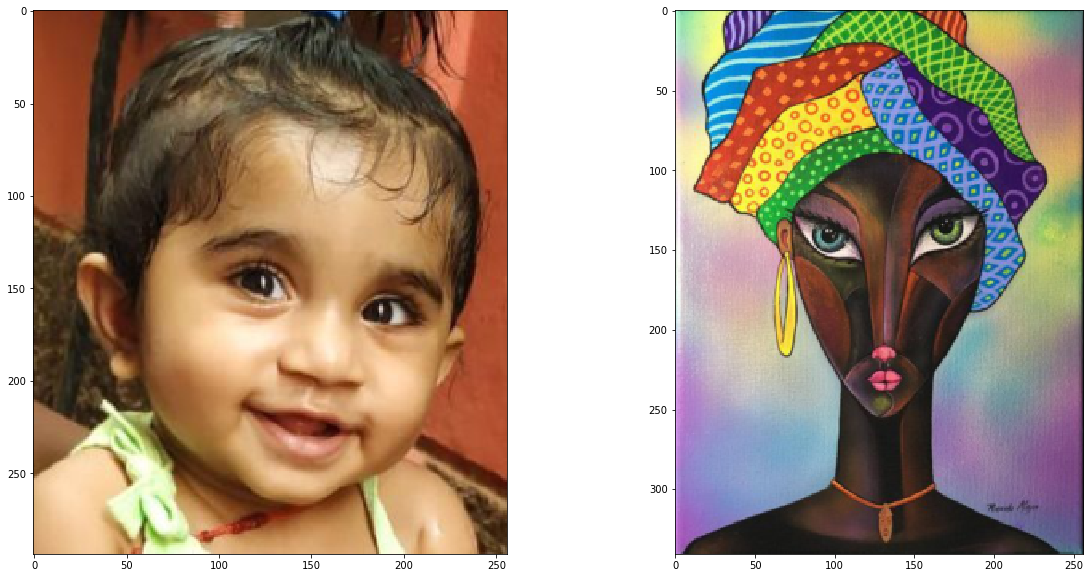

In [6]:
content_tf = test_transform(256, False)
style_tf = test_transform(256, False)

content_image = content_tf(Image.open(str("../input/face/baby.jpg")))
style_image = style_tf(Image.open(str("../input/face/ricardo-maya-acrylic-1.jpg")))

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content_image))
ax2.imshow(im_convert(style_image))

In [7]:
save_dir = Path("../new_models")
save_dir.mkdir(exist_ok=True, parents=True)
log_dir = Path("../logs")
log_dir.mkdir(exist_ok=True, parents=True)
writer = SummaryWriter(log_dir=str(log_dir))

decoder = net.decoder
vgg = net.vgg

network = net.Net(vgg, decoder)
network.train()
network.to(device)

content_tf = train_transform()
style_tf = train_transform()

content_dataset = FlatFolderDataset("../custom/content", content_tf)
style_dataset = FlatFolderDataset("../custom/style", style_tf)

In [8]:
batch_size = 8
max_iter = 1000
content_weight = 1.0
style_weight = 10.0
n_threads = 1
lr = 1e-4
save_model_interval = 100
lr_decay = 5e-5

In [9]:
def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr_new = lr / (1.0 + lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_new

In [10]:
content_iter = iter(data.DataLoader(
    content_dataset, batch_size=batch_size,
    sampler=InfiniteSamplerWrapper(content_dataset),
    num_workers=n_threads))
style_iter = iter(data.DataLoader(
    style_dataset, batch_size=batch_size,
    sampler=InfiniteSamplerWrapper(style_dataset),
    num_workers=n_threads))

optimizer = torch.optim.Adam(network.decoder.parameters(), lr=lr)
"""
for i in tqdm(range(max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    content_images = next(content_iter).to(device)
    style_images = next(style_iter).to(device)
    loss_c, loss_s = network(content_images, style_images)
    loss_c = content_weight * loss_c
    loss_s = style_weight * loss_s
    loss = loss_c + loss_s

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % save_model_interval == 0 or (i + 1) == max_iter:
        state_dict = net.decoder.state_dict()
        writer.add_scalar('loss_content', loss_c.item(), i + 1)
        writer.add_scalar('loss_style', loss_s.item(), i + 1)
        #for key in state_dict.keys():
            #state_dict[key] = state_dict[key].to(torch.device('cpu'))
        torch.save(state_dict, save_dir/'decoder_iter.pth')
"""
writer.close()

In [11]:
#exit

In [12]:
decoder.load_state_dict(torch.load("../new_models/decoder_iter.pth"))

<All keys matched successfully>

In [13]:
decoder.eval()
vgg.eval()

Sequential(
  (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (1): ReflectionPad2d((1, 1, 1, 1))
  (2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (8): ReflectionPad2d((1, 1, 1, 1))
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): ReflectionPad2d((1, 1, 1, 1))
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=True)
  (15): ReflectionPad2d((1, 1, 1, 1))
  (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (17): ReLU()
  (18): ReflectionPad2d((1, 1, 1, 1))
  (19): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (20): ReLU()
  (21): ReflectionPad2d((1, 1, 1, 1))
  (22): Conv2d(256, 256, kernel_size=(

In [14]:
weights = [1,1,1,1]
interpolation_weights = [w / sum(weights) for w in weights]
print(interpolation_weights)

[0.25, 0.25, 0.25, 0.25]


In [15]:
style_image = style_image.to(device).unsqueeze(0)
content_image = content_image.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content_image, style_image, 1.0)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
output_name = '../output/outputimage.jpg'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(output))
#save_image(output, str(output_name))